In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def show_image(img, title='Image', cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

## Loading and Resizing Image

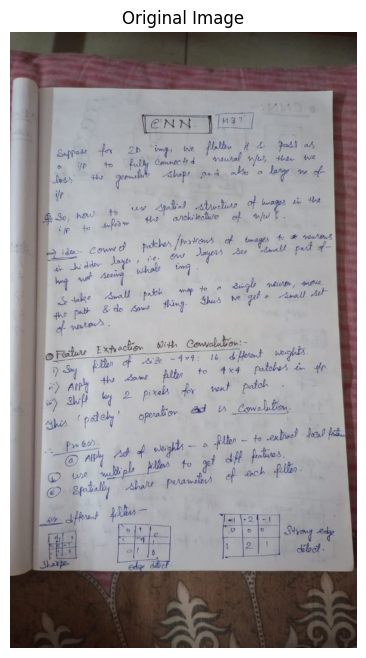

In [24]:
image_path = 'doc.jpg'
image = cv2.imread(image_path)
orig = image.copy()

show_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), title="Original Image", cmap=None)

ratio = image.shape[0] / 500.0
resized = cv2.resize(image, (int(image.shape[1] / ratio), 500))

## Edge Detection

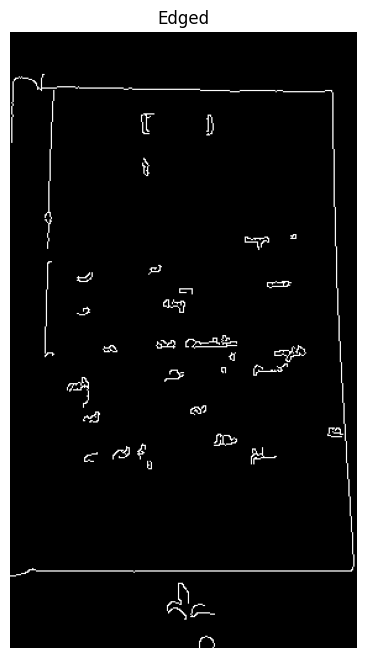

In [25]:
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

show_image(edged, title="Edged")

## Contour Detection

No 4-point document contour found. Using the largest one as fallback.


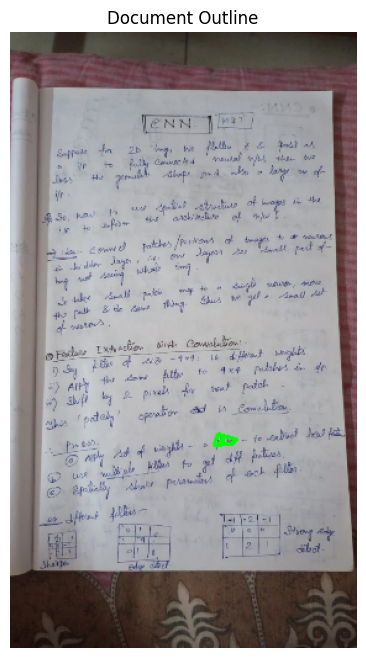

In [26]:
cnts, _ = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

doc_cnt = None
for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        doc_cnt = approx
        break

if doc_cnt is None:
    print("No 4-point document contour found. Using the largest one as fallback.")
    doc_cnt = max(cnts, key=cv2.contourArea)
    doc_cnt = cv2.approxPolyDP(doc_cnt, 0.02 * cv2.arcLength(doc_cnt, True), True)

cv2.drawContours(resized, [doc_cnt], -1, (0, 255, 0), 2)
show_image(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB), title="Document Outline", cmap=None)


## Perspective Transformation

In [27]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect



In [28]:
print(f"doc_cnt shape: {doc_cnt.shape}")  # Check the structure


doc_cnt shape: (10, 1, 2)


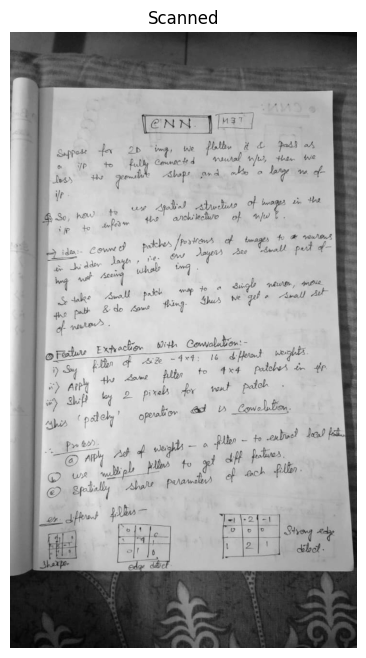

In [30]:
scanned = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
show_image(scanned, title="Scanned")

## Thresholding for better Result

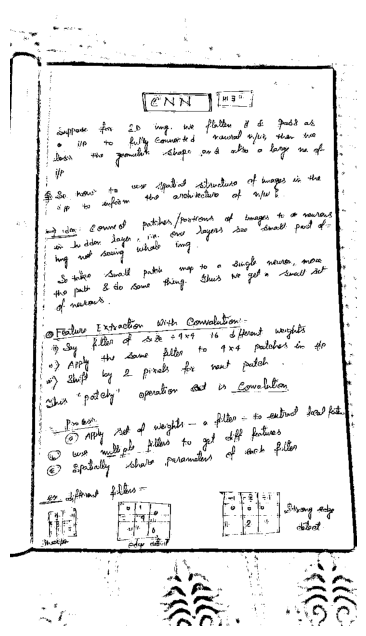

In [31]:
filtered = cv2.bilateralFilter(scanned, d=12, sigmaColor=75, sigmaSpace=75)

thresh = cv2.adaptiveThreshold(
    filtered, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    11, 2
)
show_image(thresh, title="")

## Saving the Output

In [32]:
cv2.imwrite("scanned_output.jpg", thresh)

True